# Basic LSDB/HiPSCat Functionality

### To Note:
`lsdb.Catalog` and `hipscat.Catalog` aren't exactly the same! The `lsdb.Catalog` class is just a distributed analysis engine of the `hipscat.Catalog` class. It has the ability to be aware of each catalog's partitioning structure, and utilize that in optimized spatial computations. 

### In this notebook we will...
demonstrate analysis of a single hipscat using lsdb (Large Survey DataBase)
* querying based off of columnar information
* querying based off of conesearches, polygons
* utilize the `dask.dataframe` parallelized pandas API to concatenate methods

#### Loading our local example. 
Lazy evaluation! Even though we load this object into memory, we don't actually read any data. Just the metadata.

In [1]:
%%time
import lsdb
from pathlib import Path
path_to_local_catalog = f"{Path.home()}/shared/lincc-frameworks/data/ADASS_Tutorial/gaia_exA"

gaia = lsdb.read_hipscat(path_to_local_catalog)
gaia

CPU times: user 6.53 s, sys: 14.7 s, total: 21.3 s
Wall time: 4.94 s


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
npartitions=23,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,string,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

#### Reading the column names and their types

In [2]:
dict(gaia.dtypes)

{'solution_id': dtype('int64'),
 'designation': string[pyarrow],
 'source_id': dtype('int64'),
 'random_index': dtype('int64'),
 'ref_epoch': dtype('float64'),
 'ra': dtype('float64'),
 'ra_error': dtype('float64'),
 'dec': dtype('float64'),
 'dec_error': dtype('float64'),
 'parallax': dtype('float64'),
 'parallax_error': dtype('float64'),
 'parallax_over_error': dtype('float64'),
 'pm': dtype('float64'),
 'pmra': dtype('float64'),
 'pmra_error': dtype('float64'),
 'pmdec': dtype('float64'),
 'pmdec_error': dtype('float64'),
 'ra_dec_corr': dtype('float64'),
 'ra_parallax_corr': dtype('float64'),
 'ra_pmra_corr': dtype('float64'),
 'ra_pmdec_corr': dtype('float64'),
 'dec_parallax_corr': dtype('float64'),
 'dec_pmra_corr': dtype('float64'),
 'dec_pmdec_corr': dtype('float64'),
 'parallax_pmra_corr': dtype('float64'),
 'parallax_pmdec_corr': dtype('float64'),
 'pmra_pmdec_corr': dtype('float64'),
 'astrometric_n_obs_al': dtype('int64'),
 'astrometric_n_obs_ac': dtype('int64'),
 'astrome

### Reading only the columns we care about
This greatly speeds up computation time and is better for memory consumption.

In [3]:
%%time
#load the catalog as a dask dataframe

gaia = lsdb.read_hipscat(path_to_local_catalog, columns=['ra', 'dec', 'pmra', 'pmdec'])
gaia

CPU times: user 28.6 ms, sys: 10.5 ms, total: 39.1 ms
Wall time: 31.7 ms


,ra,dec,pmra,pmdec
npartitions=23,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


### Loading a hipscat from a pandas DataFrame

Say you have a small enough dataset you can load into a single dataframe. You can instantiate a hipscat catalog from just a single dataframe!
```python
lsdb.from_dataframe(
    df,                #pandas.DataFrame,
    catalog_name,      #str
    ra_column,         #str -> name of Right Ascension column in df. Values must be decimal
    dec_column,        #str -> name of Declination column in df. Values must be decimal
    set_hipscat_index, #bool
)
```

In [ ]:
%%time
import pandas as pd

#load a parquet file as a pandas DataFrmae
path_to_parquet = f"{Path.home()}/shared/lincc-frameworks/data/ADASS_Tutorial/gaia_exA/cache/GaiaSource_000000-003111.parquet"
df = pd.read_parquet(path_to_parquet, columns=['ra', 'dec', 'pmra', 'pmdec'])


df_hipscat = lsdb.from_dataframe(df, catalog_name="GaiaSource_1", ra_column="ra", dec_column="dec", set_hipscat_index=False)
df_hipscat

### Saving a `hipscat.Catalog` result to disk


In [ ]:
df_hipscat.to_hipscat(path=f"{Path.home()}/shared/lincc-frameworks/data/ADASS_Tutorial/output")

## Lazy Evaluation and Parallelized python infrastructure
Our computations rely on the `dask.dataframe` API, which as you can see hasn't evaluated anything. For all `dask.dataframe` computations, the scheduled process aren't executed until you perform a `.compute()` at the end of the line of code. 

When utilizing this API, we can define a client to specify the number of workers, the address/port in two ways:
* with `dask.distributed` [client](https://distributed.dask.org/en/latest/client.html#dask)
* with `dask_on_ray`'s [scheduler](https://docs.ray.io/en/latest/ray-more-libs/dask-on-ray.html#scheduler)

We have personally found Dask on Ray to be better at scheduling and memory management, so we encourage others to use that.

In [5]:
%%time
from dask.distributed import Client
import ray
from ray.util.dask import enable_dask_on_ray, disable_dask_on_ray

class lsdb_client():
    def __init__(self, dask_on_ray=True, num_workers=4):
        self.dask_on_ray = dask_on_ray
        self.num_workers=num_workers
        self.start()

    def start(self):

        if self.dask_on_ray:
            self.client = ray.init(
                num_cpus=self.num_workers
            )
            enable_dask_on_ray()
        else:
            self.client = Client(n_workers=self.num_workers, threads_per_worker=1)

    def shutdown(self):
        if self.dask_on_ray:
            disable_dask_on_ray()
            ray.shutdown()
        else:
            self.client.close()

client = lsdb_client(dask_on_ray=True, num_workers=8)

2023-11-05 00:24:13,759	INFO worker.py:1621 -- Started a local Ray instance.


CPU times: user 307 ms, sys: 314 ms, total: 621 ms
Wall time: 4.16 s


/astro/users/sdwyatt/anaconda3/envs/lsdb_demo/lib/python3.10/site-packages/dask/config.py:694: UserWarning: Configuration key "shuffle" has been deprecated. Please use "dataframe.shuffle.algorithm" instead
  warnings.warn(


## Actually performing some computations

Now that we have our parallelized framework set up. Let's analyze our dataset with the LSDB codebase:
* performing cone searches
* querying based off of column info
* assigning columns
    * concatenating all this functionality

In [6]:
%%time
cone_search = gaia.cone_search(
    ra=45,    #decimal degrees
    dec=25,   #decimal degrees
    radius=1  #degrees
)
cone_search

CPU times: user 21 ms, sys: 4.32 ms, total: 25.3 ms
Wall time: 23.2 ms


,ra,dec,pmra,pmdec
npartitions=1,,,,
,float64,float64,float64,float64
,...,...,...,...


We still haven't touched any data! The next operation will likely take a few seconds since we're not being lazy anymore.

In [7]:
type(cone_search)

lsdb.catalog.catalog.Catalog

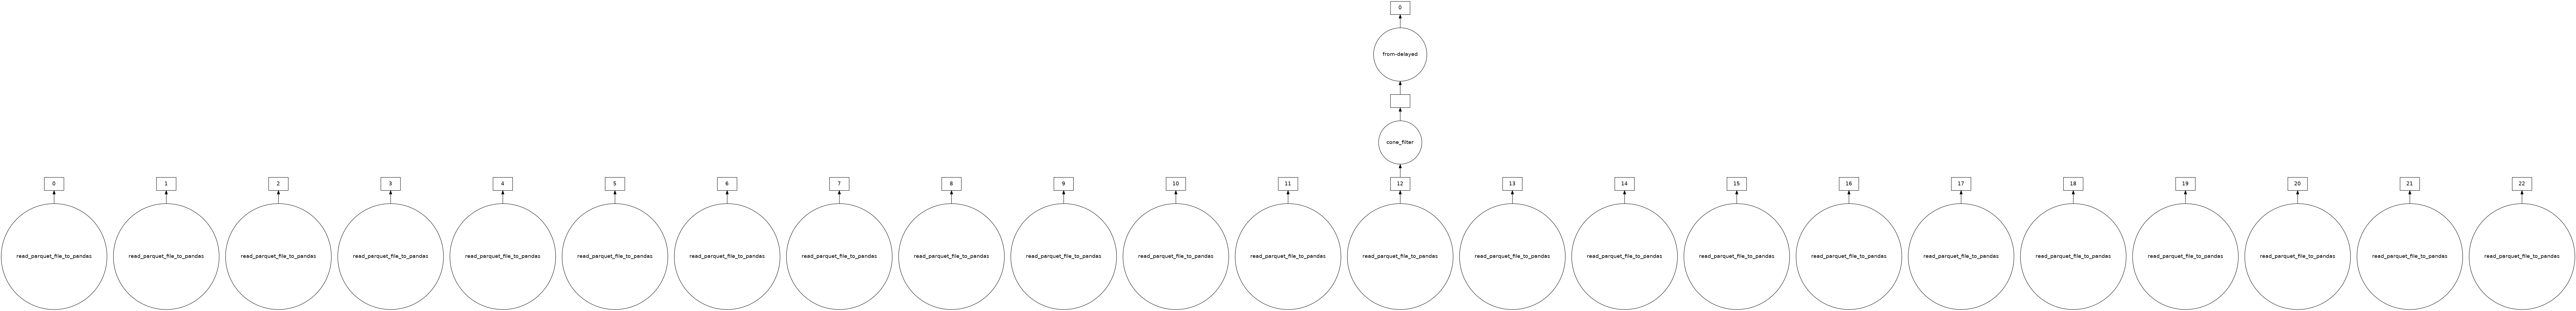

In [8]:
cone_search._ddf.visualize()

In [9]:
%%time
cone_search.compute()

CPU times: user 96.4 ms, sys: 56 ms, total: 152 ms
Wall time: 7.27 s


,ra,dec,pmra,pmdec
_hipscat_index,,,,
220509169856282624,45.247138,24.034937,0.293153,0.554729
220509188281860096,45.263956,24.033004,0.786787,-3.110927
220509226559078400,45.260434,24.039723,NaN,NaN
220509226651353088,45.260319,24.039885,-9.412184,-39.872999
220513018612547584,45.098642,24.011344,-0.646467,-2.608970
...,...,...,...,...
230528647943946240,44.998439,25.986789,-0.349472,-0.794730
230528747667718144,44.965760,25.989048,-3.958474,-2.130091
230528771755606016,44.976662,25.990917,8.380902,-7.130819


### Now lets perform the same computation but let's use the LSDB api to create a new column

by using the `dask.dataframe.assign` method

These operations are going to be on data we've already loaded, and so should be quick again.

In [10]:
%%time
import numpy as np

gaia.cone_search(
    ra=45,
    dec=25,
    radius=1
).assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
).compute()

CPU times: user 75 ms, sys: 22.8 ms, total: 97.8 ms
Wall time: 357 ms


,ra,dec,pmra,pmdec,pm
_hipscat_index,,,,,
220509169856282624,45.247138,24.034937,0.293153,0.554729,0.627426
220509188281860096,45.263956,24.033004,0.786787,-3.110927,3.208879
220509226559078400,45.260434,24.039723,NaN,NaN,NaN
220509226651353088,45.260319,24.039885,-9.412184,-39.872999,40.968833
220513018612547584,45.098642,24.011344,-0.646467,-2.608970,2.687869
...,...,...,...,...,...
230528647943946240,44.998439,25.986789,-0.349472,-0.794730,0.868174
230528747667718144,44.965760,25.989048,-3.958474,-2.130091,4.495198
230528771755606016,44.976662,25.990917,8.380902,-7.130819,11.004004


### Let's go a little bit further and cull our data based off of our calculation

by using the `dask.dataframe.query` method

In [11]:
%%time
gaia.cone_search(
    ra=45,
    dec=25,
    radius=1
).assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
).query(
    'pm > 20'
).compute()

CPU times: user 81.8 ms, sys: 14.9 ms, total: 96.7 ms
Wall time: 389 ms


,ra,dec,pmra,pmdec,pm
_hipscat_index,,,,,
220509226651353088,45.260319,24.039885,-9.412184,-39.872999,40.968833
220514578591645696,45.193946,24.032580,18.983517,-23.722323,30.382932
220515809837973504,45.228007,24.083284,17.186803,-14.084305,22.220573
220516271739895808,45.147011,24.046870,28.379337,-17.816701,33.508530
220517446191153152,45.194250,24.098803,15.679830,-15.162870,21.812146
...,...,...,...,...,...
230357087857672192,44.541237,25.895919,100.359530,-69.583714,122.122596
230357783772397568,44.594387,25.929876,14.158141,-16.033825,21.390103
230528029384769536,45.009796,25.955501,19.056310,-18.498828,26.558419


### Other spatial querying methods: Polygon search

Here we give examples on querying a catalog based on results the lie within a polygon.

In [12]:
%%time
import astropy
import numpy as np

spherical_polygon = [
    [40, 50, 50, 40], #RA's
    [10, 10, 20, 20], #DECS
]
cartesian_polygon = astropy.coordinates.spherical_to_cartesian(
    1,                                #radial component
    np.deg2rad(spherical_polygon[1]), #LAT - DECs
    np.deg2rad(spherical_polygon[0]), #LON - RAs
)
gaia.polygon_search(
    np.array(cartesian_polygon).T
).compute()

CPU times: user 3.13 s, sys: 144 ms, total: 3.27 s
Wall time: 8.88 s


,ra,dec,pmra,pmdec
_hipscat_index,,,,
28689564746907648,49.793463,9.940486,-0.749942,-2.294903
28689674696392704,49.796362,9.956280,12.857930,-5.576758
28689723622948864,49.782715,9.954584,11.090926,-10.229484
28689745529798656,49.772499,9.957309,5.242261,-9.117221
28689783672799232,49.795413,9.961531,4.587204,-2.868396
...,...,...,...,...
216359997037084672,44.373131,20.095981,1.203332,-3.097836
216360113886199808,44.351074,20.097965,-0.953572,-8.107257
216360180240089088,44.362965,20.106261,-3.191877,-1.637507


### Pretty amazing results with what you can do with 4 cores and the 1.8Bn object Gaia catalog

Now let's shut down our client

In [ ]:
client.shutdown()